Reliability is given by

$$ R = \frac{N_{\mathrm{truePC}}}{N_{\mathrm{obsPC}}} = 1 - \frac{N_{\mathrm{obsFP}}}{N_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{F_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) $$

where $E = N_{\mathrm{obsFP}}/N_{\mathrm{trueFP}}$ is the false positive effectiveness, $F_{\mathrm{obsFP}} = N_{\mathrm{obsFP}}/N_{\mathrm{obsTCEs}}$ is the fraction of observed TCEs that are dispositioned as FP and $F_{\mathrm{obsPC}} = N_{\mathrm{obsPC}}/N_{\mathrm{obsTCEs}}$ is the fraction of TCEs dispositioned as PC.

We will separately measure $E$ and $F_{\mathrm{obsFP}}$ as binomial point processes with probabilities that depend on period and MES.  Once we have $F_{\mathrm{obsFP}}$ then $F_{\mathrm{obsPC}} = 1 - F_{\mathrm{obsFP}}$, assuming that $N_{\mathrm{obsTCEs}} = N_{\mathrm{obsPC}} + N_{\mathrm{obsFP}}$.

We think of TCEs as consisting of two sets: those that are dispositioned as FP and those that are dispositioned as PC.  We do this for both the observed TCEs, and for inverted/scrambled TCEs, where all TCEs are true false positives.  Then we can think of the vetting process as drawing from the set of TCEs, with a probability $r$ of selecting either PCs or FPs.  Then the probability distribution of selecting $c$ FPs from $n$ TCEs is given by the binomial distribution

$$P\{c\} = \left( \begin{array}{c} n \\ c \end{array} \right) r^c (1-r)^{n-c}.$$

To measure $E$ we use the inverted and scrambled data sets, where all detected TCEs are by definition FPs.  We define $E$ as the probability of drawing FPs from inverted/scrambled TCEs, found via the Bayesian inference $p(E|n, c) \propto p(c|E, n) p(E)$, where 
$$p(c|E, n) = \left( \begin{array}{c} n \\ c \end{array} \right) E^c (1-E)^{n-c}$$ and
$p(E)$ is a prior distribution of the probability $E$.  By putting the data on a grid indexed by $i,j$, we can fit effectiveness as a function parameterized by a vector $\theta$, $E(\theta,\mathrm{period},\mathrm{MES})$, as $p(\theta)|n_{i,j}, c_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) \propto p(c_{i,j}|\theta, n_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) p(\theta)$, where $p(\theta)$ is some prior distribution of the parameters.

To measure $F_{\mathrm{obsFP}}$ we perform a similar inference using the set of observed TCEs, and inferring the probability of drawing c FPs from n observed TCEs.  The inference in this case becomes $p(F_{\mathrm{obsFP}}|n, c) \propto p(c|F_{\mathrm{obsFP}}, n) p(F_{\mathrm{obsFP}})$, which we can parameterize interms of a function similar to effectiveness.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spec
import pandas as pd
from astropy.io import ascii
from astropy.table import Table, vstack

import sys
sys.path.insert(0, '..')
import dr25Models as funcModels

First we set the parameters space for our analysis.

In [2]:
stellarType = "GK"
scoreCut = 0.0;
if False:
    periodMin = 200;
    periodMax = 400;
#    rpMin = 0.75;
#    rpMax = 2.0;
    rpMin = 0;
    rpMax = 100;
    mesMin = 7;
    mesMax = 15;
else:
    periodMin = 50;
    periodMax = 600;
    rpMin = 0.5;
    rpMax = 15;
    mesMin = 7;
    mesMax = 30;



In [3]:
def drawHeatMap(dataArray, imageSize, x, y, nData=[], colorBarLabel="", textOn=True, forceInt=True):
    dx = x[(1,0)] - x[(0,0)];
    dy = y[(0,1)] - y[(0,0)];
    extent = [x[(0,0)], x[(-1,0)]+dx,y[(0,0)],y[(0,-1)]+dy];
    plt.figure(figsize=imageSize);
    # fig, ax = plt.subplots(figsize=imageSize);
    ax = plt.gca()

    da = np.transpose(dataArray);
    im = ax.imshow(da, extent = extent, origin='lower');
#    im = ax.imshow(da, extent = extent, origin='lower', cmap="Greys");
    ax.set_aspect(10);
    
    if len(nData) == 0:
        nData = np.ones(dataArray.shape)

    # ax.imshow(da, origin='lower');
    arrayShape = da.shape;
    minda = np.min(da)
    maxda = np.max(da)
    daRange = maxda - minda;
    for i in range(arrayShape[0]):
        for j in range(arrayShape[1]):
            if da[i, j] > minda + daRange*0.5:
                cstr = "k"
                # cstr = "w"
            else:
                cstr = "w"
                # cstr = "k"
            if np.abs(da[i,j]) < 100:
                fsz = 9
            else:
                fsz = 6
            
            if textOn:
                if nData[(j,i)] > 0:
                    if forceInt:
                        ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, da[i, j].astype("int"),
                               ha="center", va="center", color=cstr, fontsize=fsz)
                    else:
                        ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, da[i, j],
                               ha="center", va="center", color=cstr, fontsize=fsz)                        
                else:
                    ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, "-",
                           ha="center", va="center", color=cstr, fontsize=fsz)

            
    
    im_ratio = float(da.shape[0])/da.shape[1] 
    cbh = plt.colorbar(im,fraction=0.024*im_ratio, pad=0.02)
    cbh.ax.set_ylabel(colorBarLabel);

    # ax.invert_yaxis();

Then we load our data, which consists of the stellar catalog, observed TCEs, inverted TCEs and scrambled TCEs.  We convert the tables to Pandas for manipulation.

In [4]:
# not currently used
# load skygroup maps for the FOV position dependence study
# obsSkygroupMap = ascii.read("../data/obsTceToSkygroup.txt");


In [5]:
dataLoc = "../data/"

# starlist = dataLoc + "dr25_stellar_updated_feh_" + stellarType + ".txt"
starlist = "../stellarCatalogs/dr25_stellar_supp_clean_" + stellarType + ".txt"
kic = pd.read_csv(starlist)

invList = dataLoc + "kplr_dr25_inv_tces.txt"
scr1List = dataLoc + "kplr_dr25_scr1_tces.txt"
scr2List = dataLoc + "kplr_dr25_scr2_tces.txt"
scr3List = dataLoc + "kplr_dr25_scr3_tces.txt"

invTcesFull = ascii.read(invList);
scr1TcesFull = ascii.read(scr1List);
scr2TcesFull = ascii.read(scr2List);
scr3TcesFull = ascii.read(scr3List);

invTcesFullPd = invTcesFull.to_pandas();
scr1TcesFullPd = scr1TcesFull.to_pandas();
scr2TcesFullPd = scr2TcesFull.to_pandas();
scr3TcesFullPd = scr3TcesFull.to_pandas();


We have to remove the TCEs that are on the drop lists

In [6]:
invDropList = ascii.read(dataLoc + "kplr_droplist_inv.txt");
scr1DropList = ascii.read(dataLoc + "kplr_droplist_scr1.txt");
scr2DropList = ascii.read(dataLoc + "kplr_droplist_scr2.txt");
scr3DropList = ascii.read(dataLoc + "kplr_droplist_scr3.txt");
invDropList = invDropList.to_pandas();
scr1DropList = scr1DropList.to_pandas();
scr2DropList = scr2DropList.to_pandas();
scr3DropList = scr3DropList.to_pandas();

invTcesPd = invTcesFullPd[~invTcesFullPd['TCE_ID'].isin(invDropList['TCE_ID'])];
scr1TcesPd = scr1TcesFullPd[~scr1TcesFullPd['TCE_ID'].isin(scr1DropList['TCE_ID'])];
scr2TcesPd = scr2TcesFullPd[~scr2TcesFullPd['TCE_ID'].isin(scr2DropList['TCE_ID'])];
scr3TcesPd = scr3TcesFullPd[~scr3TcesFullPd['TCE_ID'].isin(scr3DropList['TCE_ID'])];

print("length of invTcesFull = " + str(len(invTcesFullPd)) 
      + ", length of invTces = " + str(len(invTcesPd)))
print("length of scr1TcesFull = " + str(len(scr1TcesFullPd)) 
      + ", length of scr1Tces = " + str(len(scr1TcesPd)))
print("length of scr2TcesFull = " + str(len(scr2TcesFullPd)) 
      + ", length of scr2Tces = " + str(len(scr2TcesPd)))
print("length of scr3TcesFull = " + str(len(scr3TcesFullPd)) 
      + ", length of scr3Tces = " + str(len(scr3TcesPd)))

length of invTcesFull = 19531, length of invTces = 14952
length of scr1TcesFull = 24209, length of scr1Tces = 13778
length of scr2TcesFull = 24217, length of scr2Tces = 13817
length of scr3TcesFull = 19811, length of scr3Tces = 9240


Now convert back to astropy tables, and combine the scrambled TCEs into one list

In [7]:
invTces = Table.from_pandas(invTcesPd)
scr1Tces = Table.from_pandas(scr1TcesPd)
scr2Tces = Table.from_pandas(scr2TcesPd)
scr3Tces = Table.from_pandas(scr3TcesPd)

# create a final set of scrambled TCEs
scrTces = vstack([scr1Tces, scr2Tces, scr3Tces])
# scrTces = scr1Tces

print("length of scrTces = " + str(len(scrTces)))

length of scrTces = 36835


Resstrict to the chosen stellar population

In [8]:
invTces = invTces[np.in1d(invTces['KIC'],kic.kepid)]
scrTces = scrTces[np.in1d(scrTces['KIC'],kic.kepid)]

print("length of invTces = " + str(len(invTces)))
print("length of scrTces = " + str(len(scrTces)))


length of invTces = 1394
length of scrTces = 4691


There are three examples of TCEs compared to one set of inverted TCEs.  So maybe subsample the scrTCEs by a factor of three.

In [9]:
subSample = np.random.rand(len(scrTces))
# scrTcesSub = scrTces[subSample < 1./3]
scrTcesSub = scrTces
print("length of scrTcesSub = " + str(len(scrTcesSub)))

length of scrTcesSub = 4691


Create the final list of synthetic FPs by concatanating the inverted and subset of the scrambled lists.

In [10]:
# syntheticTrueFps = vstack([invTces,scrTcesSub])
syntheticTrueFps = vstack([invTces,invTces,invTces,scrTcesSub])
print("length of syntheticTrueFps = " + str(len(syntheticTrueFps)))

length of syntheticTrueFps = 8873


Restrict to the desired radius and period range

In [11]:
spIndex = np.where(np.all([
    syntheticTrueFps['Rp']>rpMin,syntheticTrueFps['Rp']<rpMax,\
    syntheticTrueFps['period']>periodMin,syntheticTrueFps['period']<periodMax], axis=0))
spSyntheticTrueFps = syntheticTrueFps[spIndex]

print("length of spSyntheticTrueFps = " + str(len(spSyntheticTrueFps)))


length of spSyntheticTrueFps = 7609


Separate out the dispositioned PC and FPs

In [12]:
# spSyntheticPcs = spSyntheticTrueFps[(spSyntheticTrueFps['NTL']==0)  & (spSyntheticTrueFps['SS']==0)
#                                      & (spSyntheticTrueFps['CO']==0) & (spSyntheticTrueFps['Score']>=scoreCut)]
# spSyntheticFps = spSyntheticTrueFps[(spSyntheticTrueFps['NTL']==1) | (spSyntheticTrueFps['SS']==1)
#                                      | (spSyntheticTrueFps['CO']==1) | (spSyntheticTrueFps['Score']<scoreCut)]

spSyntheticPcs = spSyntheticTrueFps[(spSyntheticTrueFps['Disp']=='PC') & (spSyntheticTrueFps['Score']>=scoreCut)]
spSyntheticFps = spSyntheticTrueFps[(spSyntheticTrueFps['Disp']=='FP') | (spSyntheticTrueFps['Score']<scoreCut)]

print("length of spSyntheticPcs = " + str(len(spSyntheticPcs)))
print("length of spSyntheticFps = " + str(len(spSyntheticFps)))


length of spSyntheticPcs = 93
length of spSyntheticFps = 7516


Let's see what this population looks like.

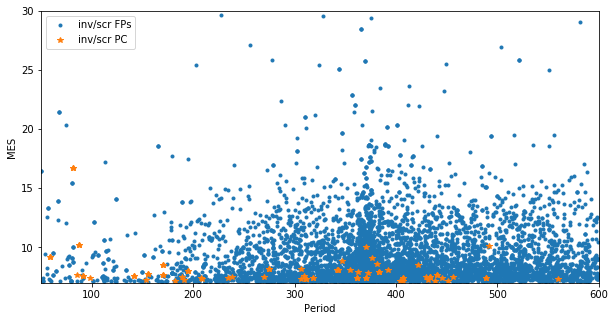

In [13]:
plt.figure(figsize=(10,5));
# plt.subplot(2,2,1);
plt.plot(spSyntheticFps['period'], spSyntheticFps['MES'], ".", 
        spSyntheticPcs['period'], spSyntheticPcs['MES'], "*");
plt.ylim(mesMin,mesMax);
plt.xlim(periodMin,periodMax);
plt.legend(("inv/scr FPs", "inv/scr PC"));
plt.ylabel('MES');
plt.xlabel('Period');


Bin the data so we have n TCEs and c FPs in each bin.

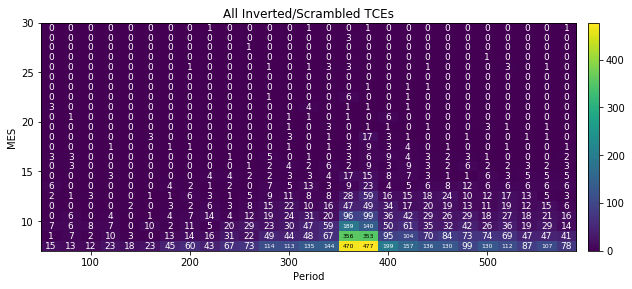

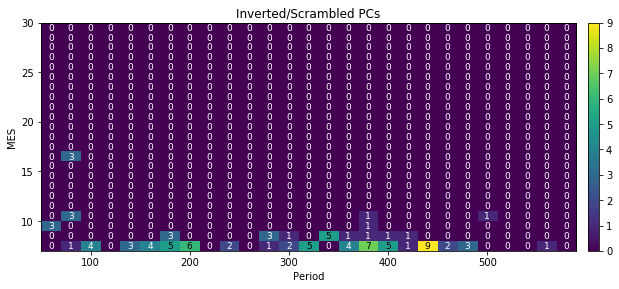

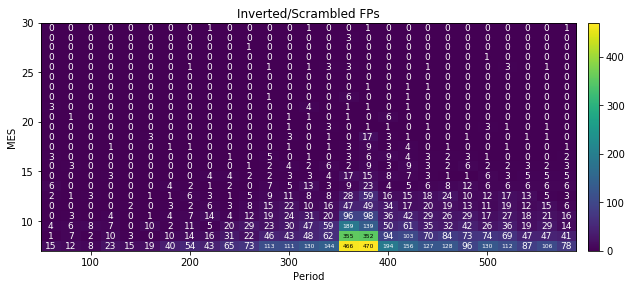

In [14]:

dPeriod = 20; 
dMes = 1;

p0 = periodMin;
pEnd = periodMax;
m0 = mesMin;
mEnd = mesMax;

# make the period-mes grid
NPeriod = int((pEnd - p0)/dPeriod);
NMes = int((mEnd - m0)/dMes);
tceGrid = np.zeros((NPeriod,NMes));
cellPeriod = np.zeros((NPeriod,NMes));
cellMes = np.zeros((NPeriod,NMes));
pcGrid = np.zeros((NPeriod,NMes));
fpGrid = np.zeros((NPeriod,NMes));

# count how many points are in each cell
for p in range(NPeriod):
    for m in range(NMes):
        cellPeriod[(p,m)] = p0 + p*dPeriod;
        cellMes[(p,m)] = m0 + m*dMes;
        pointsInCell = np.where(
            (spSyntheticTrueFps['period'] > cellPeriod[(p,m)]) 
            & (spSyntheticTrueFps['period'] <= cellPeriod[(p,m)]+dPeriod) 
            & (spSyntheticTrueFps['MES'] > cellMes[(p,m)]) 
            & (spSyntheticTrueFps['MES'] <= cellMes[(p,m)]+dMes));
        tceGrid[(p,m)] = len(pointsInCell[0]);

        pointsInCell = np.where(
            (spSyntheticPcs['period'] > cellPeriod[(p,m)]) 
            & (spSyntheticPcs['period'] <= cellPeriod[(p,m)]+dPeriod) 
            & (spSyntheticPcs['MES'] > cellMes[(p,m)]) 
            & (spSyntheticPcs['MES'] <= cellMes[(p,m)]+dMes));
        pcGrid[(p,m)] = len(pointsInCell[0]);

        pointsInCell = np.where(
            (spSyntheticFps['period'] > cellPeriod[(p,m)]) 
            & (spSyntheticFps['period'] <= cellPeriod[(p,m)]+dPeriod) 
            & (spSyntheticFps['MES'] > cellMes[(p,m)]) 
            & (spSyntheticFps['MES'] <= cellMes[(p,m)]+dMes));
        fpGrid[(p,m)] = len(pointsInCell[0]);

        
drawHeatMap(tceGrid, (10,5), cellPeriod, cellMes);           
plt.title("All Inverted/Scrambled TCEs");
plt.ylabel('MES');
plt.xlabel('Period');
drawHeatMap(pcGrid, (10,5), cellPeriod, cellMes);           
plt.title("Inverted/Scrambled PCs");
plt.ylabel('MES');
plt.xlabel('Period');
drawHeatMap(fpGrid, (10,5), cellPeriod, cellMes);           
plt.title("Inverted/Scrambled FPs");
plt.ylabel('MES');
plt.xlabel('Period');



Compute the PC and FC fractions in each cell to get a sense of what the fractions look like.  These are not used in the inference.

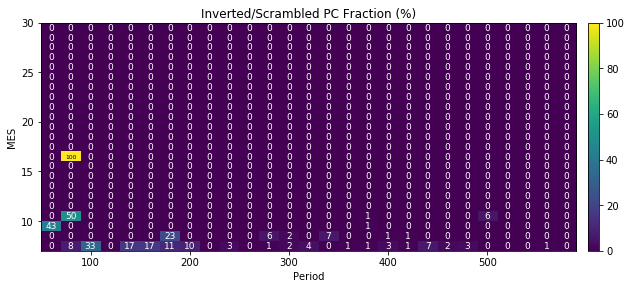

In [15]:
minTcePerCell = 0;

pcFrac = np.zeros(np.shape(tceGrid))
pcFrac[tceGrid>minTcePerCell] = pcGrid[tceGrid>minTcePerCell]/tceGrid[tceGrid>minTcePerCell];
drawHeatMap(np.round(100*pcFrac), (10,10), cellPeriod, cellMes);           
plt.title("Inverted/Scrambled PC Fraction (%)");
plt.ylabel('MES');
plt.xlabel('Period');


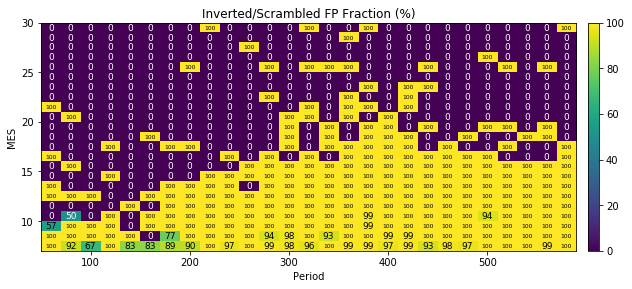

In [16]:
fpFrac = np.zeros(np.shape(tceGrid))
fpFrac[tceGrid>minTcePerCell] = fpGrid[tceGrid>minTcePerCell]/tceGrid[tceGrid>minTcePerCell];
drawHeatMap(np.round(100*fpFrac), (10,10), cellPeriod, cellMes);           
plt.title("Inverted/Scrambled FP Fraction (%)");
plt.ylabel('MES');
plt.xlabel('Period');


Prepare the data for the call to emcee to do the Bayesian inference.

In [17]:

cFp = fpGrid.flatten();
nTce = tceGrid.flatten();

# convert to homogeneous coordinates on unit square [0,1]
cellX, cellY = funcModels.normalizeRange(cellPeriod, cellMes, [periodMin, periodMax], [mesMin, mesMax]);
gridShape = np.shape(cellX);
dx = 1./gridShape[0];
dy = 1./gridShape[1];
print("gridShape = " + str(gridShape) + ", dx = " + str(dx) + ", dy = " + str(dy))

cellXFlat = cellX.flatten();
cellYFlat = cellY.flatten();

cFp[nTce<minTcePerCell] = 0;
nTce[nTce<minTcePerCell] = 0;

tceData = [cellXFlat, cellYFlat, nTce, cFp];

gridShape = (27, 23), dx = 0.037037037037, dy = 0.0434782608696


We're ready to compute a Bayesian inference of the success probability $r$:

$$p(r|c, n) \propto p(c|r, n) p(r).$$

But we're computing $r$ as a function of period $p$, MES $m$, and parameters $\theta$, $r(\theta, p, m)$. So our inference becomes 

$$p(\theta|c, n, p, m) \propto p(c|\theta, n, p, m) p(\theta).$$

Because each cell is independent, we linearize the array to a list of cells indexed by $k$.  Then the likelihood for each cell is

$$p(c_k|\theta, n_k, p_k, m_k) = \left( \begin{array}{c_k} n_k \\ c_k \end{array} \right) r(\theta, p_k , m_k )^{c_k} (1-r(\theta, p_k , m_k ))^{n_k-c_k}$$

Because the $N$ cells are independent, the likelihood for the collection of cells is

$$p(c|\theta, n, p, m) \equiv p(c_1, \ldots, c_N|\theta, n_1, \ldots, n_N, p_1, \ldots, p_N, m_1, \ldots, m_N) = \prod_k \left( \begin{array}{c_k} n_k \\ c_k \end{array} \right) r(\theta, p_k , m_k )^{c_k} (1-r(\theta, p_k , m_k ))^{n_k-c_k}.$$

The log-likelihood is then

$$\log p(c|\theta, n, p, m) = \sum_k \log \left(\left( \begin{array}{c_k} n_k \\ c_k \end{array} \right) r(\theta, p_k , m_k )^{c_k} (1-r(\theta, p_k , m_k ))^{n_k-c_k} \right)$$ 
$$= \sum_k \left[ \log \left(\begin{array}{c_k} n_k \\ c_k \end{array} \right) + c_k \log \left(r(\theta, p_k , m_k ) \right) + \left( n_k-c_k \right) \log(1-r(\theta, p_k , m_k )) \right] $$

Define a nice collection of models to play with.

Define the likelihood and prior functions.

In [18]:
def lnBinlike(theta, data, model):
    x, y, n, c = data
    r = funcModels.rateModel(x,y,theta,model);
    clnr = c*np.log(r);
    clnr[c==0] = 0;
    lpl = np.sum(np.log(spec.comb(n,c)) + clnr + (n-c)*np.log(1-r));
        
    return lpl

def lnBinprior(theta, data, model):
    x, y, n, c = data

    # print(theta)
    if model == "constant":
        if 0.0 <= theta[0] <= 1:
            return 1.0
    elif model == "linearX":
        if -5000.0 < theta[0] < 5000.0 and 0.0 < theta[1] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "linearXY":
        if -5000.0 < theta[0] < 5000.0 and -5000.0 < theta[1] < 5000.0 \
        and 0.0 < theta[2] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "gaussian":
        if 0.45 < theta[0] < 1 and 0 <= theta[1] < 0.5 \
        and 1e-2 < theta[2] < 10 and 1e-2 < theta[3] < 10 and -1 <= theta[4] <= 1 and 0 <= theta[5] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticX":
        if -1 < theta[0] < 2.0 \
        and 1e-4 < theta[1] < 1e4 and 0 < theta[2] < 1e6 and 0 < theta[3] < 1e6 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticY":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 100 and 0 < theta[2] <= 0.1 and 0.9 < theta[3] <= 1 \
        and 0 < theta[2] + theta[3] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticY":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 100 and -180 < theta[2] <= 180 \
        and 0 < theta[3] <= 0.2 and 0.8 < theta[4] <= 1 \
        and 0 < theta[3] + theta[4] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticY2":
        if -1 <= theta[0] <= 2 and 1e-4 < theta[1] < 100 \
        and 0.1 < theta[2] <= 1000 and -180 < theta[3] <= 180 \
        and 0 < theta[4] <= 0.2 and 0.8 < theta[5] <= 1 \
        and 0 < theta[4] + theta[5] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticYXFixedLogisticY":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 100 and -180 < theta[2] <= 180 \
        and 0 < theta[3] <= 0.2 and 0.8 < theta[4] <= 1 \
        and 0 < theta[3] + theta[4] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticYXLogisticY":
        if -1 <= theta[0] <= 2 and 1e-4 < theta[1] < 100 \
        and -1 <= theta[2] <= 2 and 1e-4 < theta[3] < 100 \
        and -180 < theta[4] <= 180 \
        and 0 < theta[5] <= 0.2 and 0.8 < theta[6] <= 1 \
        and 0 < theta[5] + theta[6] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticY2":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 1e4 and 0.1 < theta[2] <= 1000 and 0 < theta[3] <= 0.1 and 0.9 < theta[4] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticX0":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 1e4 and 0 < theta[2] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticY0":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 1e4 and 0 < theta[2] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticY02":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 1e4 and 0.1 < theta[2] <= 1000 and 0 < theta[3] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticX0xlogisticY0":
        if 0 <= theta[0] <= 1e3 and 0 <= theta[1] <= 1e3 \
        and 1e-4 < theta[2] < 1e4 and 1e-4 < theta[3] < 1e4 \
        and 0 < theta[4] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticX0xlogisticY0":
        if -1 <= theta[0] <= 2 and -1 <= theta[1] <= 2 \
        and 1e-4 < theta[2] < 1e4 and 1e-4 < theta[3] < 1e4 \
        and -3 < theta[4] < 3 and -180 < theta[5] < 180 \
        and 0 < theta[6] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticX0":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 100 and 0 < theta[2] <= 1  and -180 < theta[3] < 180 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticX02":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 100 and 0.1 < theta[2] <= 1000 and 0 < theta[3] <= 1  and -180 < theta[4] < 180 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticX0+gaussian":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 100 and 0 < theta[2] <= 1  and -180 < theta[3] < 180 \
        and 0.45 < theta[4] < 1 and 0 <= theta[5] < 0.5 \
        and 1e-2 < theta[6] < 2 and 1e-2 < theta[7] < 2 and -1 <= theta[8] <= 0 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "dualBrokenPowerLaw":
        # print(funcModels.rateModel(x, y, theta, model))
        if 0 <= theta[0] <= 1 and 0 <= theta[1] <= 1 \
        and -2 < theta[2] < 0 and -2 < theta[3] < 0 and 0 < theta[4] < 1e4 and 0 < theta[5] < 1e4 \
        and 0 < theta[6] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    else:
        raise ValueError('Bad model name');
        
    # print(theta)
    return -np.inf

def lnBinprob(theta, data, model):
    lp = lnBinprior(theta, data, model)
    # print("lnPoisprior = " + str(lp))
    if not np.isfinite(lp):
        return -np.inf
    # print(str(lnPoislike(theta, A, c)))
    return lp + lnBinlike(theta, data, model)



Fit the effectiveness.  We perform the MCMC calculation of the log posterior.  We use a manual three-part strategy to find the best seed point: first we use the initial values in the model definitions.  This MCMC result is used to seed the second iterations, whose result is used to seed the third and final iteration.  We then initialize the MCMC walkers with a small Gaussian distribution around these starting points.

In [19]:
model = "rotatedLogisticX0"

if model == "constant":
    initialPos = funcModels.initRateModel(model);
elif model == "logisticY0":
    initialPos = funcModels.initRateModel(model);
elif model == "logisticY":
    initialPos = [-2.63785585e-02,  20,  0.02,  0.98];
elif model == "rotatedLogisticY":
    # initialPos = [  0.04944521,  23.31556305, -25.49590252,   0.04268818,   0.95325393];
    initialPos = [ 4.83412482e-02,  3.95216090e+01, -3.82447066e+01,  3.88681300e-02, 9.54596550e-01]
elif model == "rotatedLogisticY2":
    initialPos = [ 4.83412482e-02,  3.95216090e+01, 1, -3.82447066e+01,  3.88681300e-02, 9.54596550e-01]
elif model == "rotatedLogisticYXLogisticY":
    initialPos = [  0.04944521,  23.31556305, -2.63785585e-02,  20,  -25.49590252,   0.04268818,   0.95325393];
elif model == "logisticY02":
    initialPos = [-1.73396324e-01,  10,  2,  9.90011008e-01];
elif model == "gaussian":
    # initialPos = funcModels.initRateModel(model);
    initialPos = [ 0.62, 0.04,  1,  1, -0.01,  9.91039169e-01]
elif model == "dualBrokenPowerLaw":
    initialPos = [ 0.96811698,  0.01257312, -0.00171099, -1e-2,   0.73671063,  0.00555828, 0.99154711]
elif model == "rotatedLogisticX0":
    initialPos = [ 1.2,  9.7715652,    0.99773284, 106.91479715];
elif model == "rotatedLogisticX02":
    initialPos = [ 1.2,  9.7715652,  1.0,  0.99773284, 106.91479715];
elif model == "rotatedLogisticX0+gaussian":
    initialPos = funcModels.initRateModel(model);
elif model == "rotatedLogisticX0xlogisticY0":
    initialPos = [ 1.50565457e+00, -3.09826269e-01,  4.92718937e+03,  1.36096954e+01, 
                  5.52126518e-02, -1.23504297e+01,  9.97222157e-01];
else:
    initialPos = funcModels.initRateModel(model);



print(initialPos)



[1.2, 9.7715652, 0.99773284, 106.91479715]


In [20]:
import scipy.optimize as op

nll = lambda *args: -lnBinlike(*args)
result = op.minimize(nll, initialPos, args=(tceData, model))
maxLikelihoodResult = result["x"];
    
modelLabels = funcModels.getModelLabels(model)
for i in range(0,len(maxLikelihoodResult)):
    print("maximum Likelihood " + modelLabels[i] + ":={:.3f}".format(maxLikelihoodResult[i]))
    
if lnBinprior(maxLikelihoodResult, tceData, model) == -np.inf:
    maxLikelihoodResult = initialPos;
    print("violates prior, replacing maxLikelihoodResult result with initialPos")
    
x, y, n, c = tceData
r = funcModels.rateModel(x,y,maxLikelihoodResult,model);
print("maximum Likelihood rate min = {:.3f}".format(np.min(np.min(r))) + ", max = {:.3f}".format(np.max(np.max(r))))




maximum Likelihood $x_0$:=514.520
maximum Likelihood $k_x$:=23.121
maximum Likelihood $A$:=898.759
maximum Likelihood $\phi$:=108.324
violates prior, replacing maxLikelihoodResult result with initialPos
maximum Likelihood rate min = 0.676, max = 0.998


/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


MCMC $x_0$:=1.373+0.073-0.067
MCMC $k_x$:=8.757+2.354-1.632
MCMC $A$:=0.999+0.001-0.002
MCMC $\phi$:=125.439+11.406-9.126
fitTheta = [  1.37283738   8.75700208   0.99877265 125.43929334]


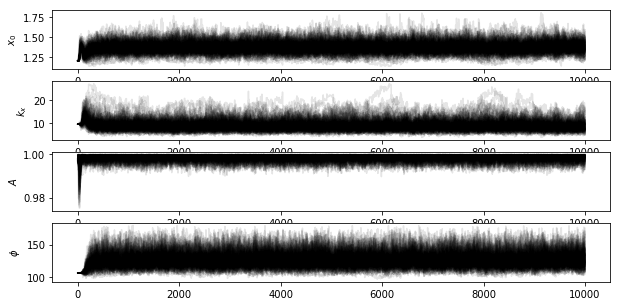

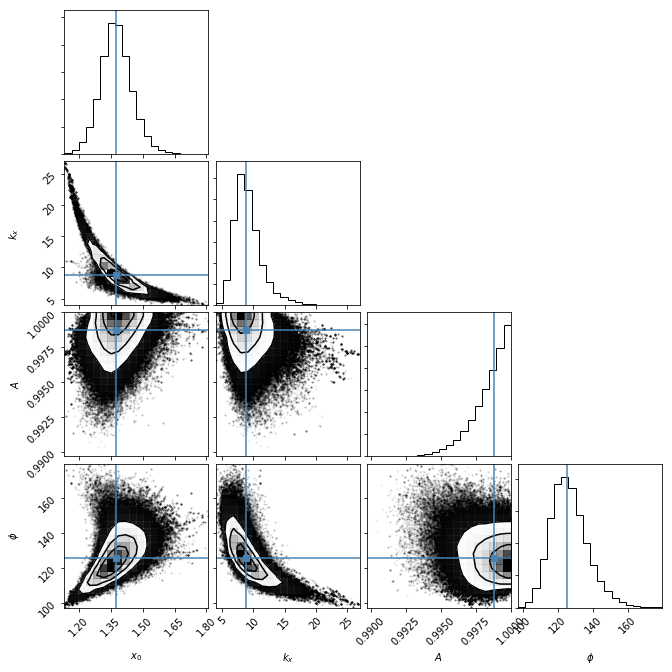

In [21]:
import emcee

ndim, nwalkers = len(maxLikelihoodResult), 100
pos = [maxLikelihoodResult + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnBinprob, args=(tceData, model))

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnBinprob, args=(cellXFlat, cellYFlat, nTce, cFp, model))

sampler.run_mcmc(pos, 10000);

samples = sampler.chain[:, 5000:, :].reshape((-1, ndim))
dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
dataResult = list(dataResult)

np.save("binEffPosteriors_" + str(model) + ".npy", samples)

modelLabels = funcModels.getModelLabels(model)
for i in range(0,ndim):
    v = dataResult[i];    
    print("MCMC " + modelLabels[i] + ":={:.3f}".format(v[0]) + "+{:.3f}".format(v[1]) + "-{:.3f}".format(v[2]))
    # print("true " + modelLabels[i] + ":={:.3f}".format(trueTheta[i]))
# print("compared to: rate={:.3f}".format(rate))

resultSize = np.shape(dataResult);
fitTheta = np.zeros(resultSize[0]);
for i in range(resultSize[0]):
    fitTheta[i] = dataResult[i][0]
print("fitTheta = " + str(fitTheta))

plt.figure(figsize=(10,5))
for i in range(0,ndim):
    plt.subplot(ndim,1,i+1)
    plt.plot(np.transpose(sampler.chain[:, :, i]), color="k", alpha=0.1);
    plt.ylabel(modelLabels[i]);


import corner
modelLabels = funcModels.getModelLabels(model)
# trueTheta = funcModels.initRateModel(model)
# fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
#                       truths=[m_true, b_true, np.log(f_true)])
fig = corner.corner(samples, labels = modelLabels, truths = fitTheta)



We test the result by reconstructing the distribution of FPs and % of FPs using binomial-distributed random numbers, to see if they match the actual data.

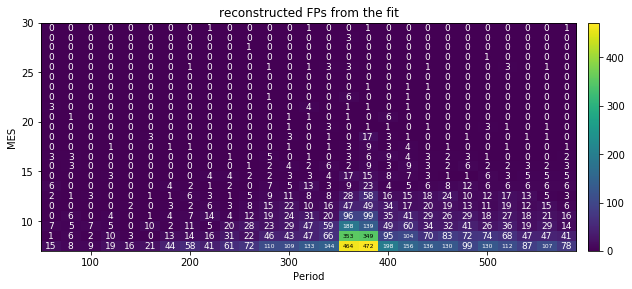

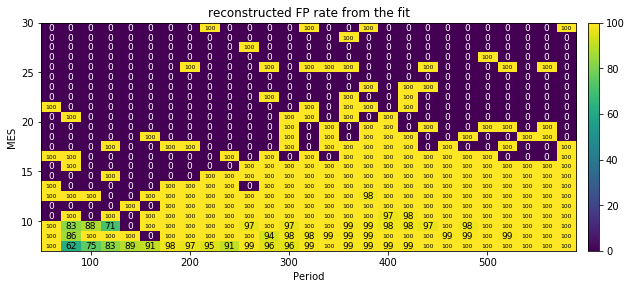

In [22]:
fitGrid = np.zeros(np.shape(tceGrid));

for p in range(NPeriod):
    for m in range(NMes):
        fitGrid[(p,m)] = np.random.binomial(tceGrid[(p,m)], 
            funcModels.rateModel(cellX[(p,m)]+dx/2, cellY[(p,m)]+dx/2, fitTheta, model), 1);
        
drawHeatMap(fitGrid, (10,10), cellPeriod, cellMes);
plt.title('reconstructed FPs from the fit');
plt.ylabel('MES');
plt.xlabel('Period');

fitFrac = np.zeros(np.shape(tceGrid))
fitFrac[tceGrid>minTcePerCell] = fitGrid[tceGrid>minTcePerCell]/tceGrid[tceGrid>minTcePerCell];
drawHeatMap(np.round(100*fitFrac), (10,10), cellPeriod, cellMes);           
plt.title('reconstructed FP rate from the fit');
plt.ylabel('MES');
plt.xlabel('Period');



In [23]:
from ipywidgets import FloatProgress
from IPython.display import display

nFits = 1000;
fitGrid = np.zeros([np.shape(tceGrid)[0],np.shape(tceGrid)[1],nFits]);
sidx = [0]*nFits
progress = FloatProgress(min=0, max=nFits)
display(progress)


for f in range(nFits):
    sidx[f] = int(np.random.uniform(high=samples.shape[0]-1));
    tTheta = samples[sidx[f],:]

    for p in range(NPeriod):
        for m in range(NMes):
            rm = funcModels.rateModel(cellX[(p,m)]+dx/2, cellY[(p,m)]+dy/2, tTheta, model)
            if rm > 1:
                rm = 1;
            fitGrid[(p,m,f)] = np.random.binomial(tceGrid[(p,m)], rm, 1);
    progress.value += 1
    
meanFit = np.mean(fitGrid, 2)
stdFit = np.std(fitGrid, 2)



FloatProgress(value=0.0, max=1000.0)

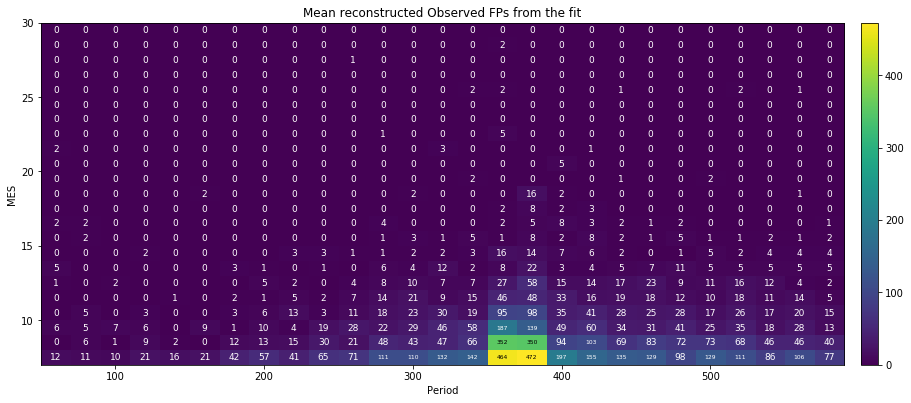

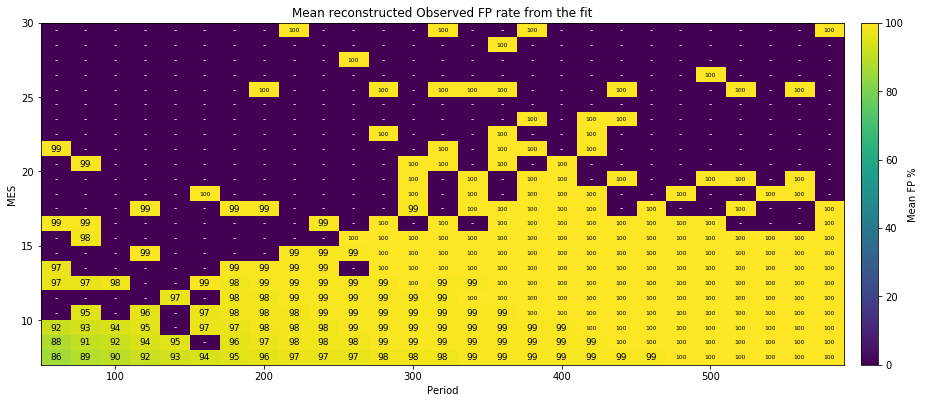

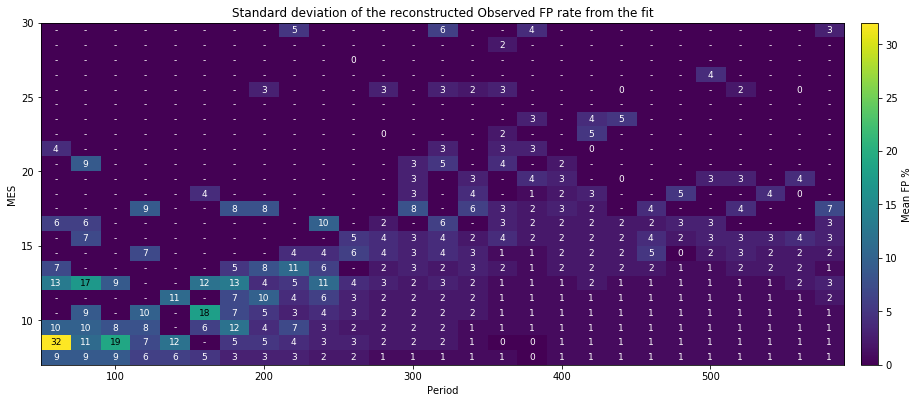

In [24]:
drawHeatMap(meanFit, (15,15), cellPeriod, cellMes);           
plt.title("Mean reconstructed Observed FPs from the fit");
plt.ylabel('MES');
plt.xlabel('Period');

fitFracMean = np.zeros(np.shape(tceGrid))
fitFracMean[tceGrid>minTcePerCell] = meanFit[tceGrid>minTcePerCell]/tceGrid[tceGrid>minTcePerCell];
drawHeatMap(np.round(100*fitFracMean), (15,15), cellPeriod, cellMes, nData = tceGrid, colorBarLabel="Mean FP %");           
plt.ylabel('MES');
plt.xlabel('Period');
plt.savefig("fpEffMean.eps",bbox_inches='tight')
plt.title("Mean reconstructed Observed FP rate from the fit");

stdFrac = np.zeros(np.shape(tceGrid))
stdFrac[tceGrid>minTcePerCell] = stdFit[tceGrid>minTcePerCell]/tceGrid[tceGrid>minTcePerCell];
drawHeatMap(np.round(100*stdFrac), (15,15), cellPeriod, cellMes, nData = tceGrid, colorBarLabel="Mean FP %");           
plt.ylabel('MES');
plt.xlabel('Period');
plt.savefig("fpEffStd.eps",bbox_inches='tight')
plt.title("Standard deviation of the reconstructed Observed FP rate from the fit");



-0.021719940267350697

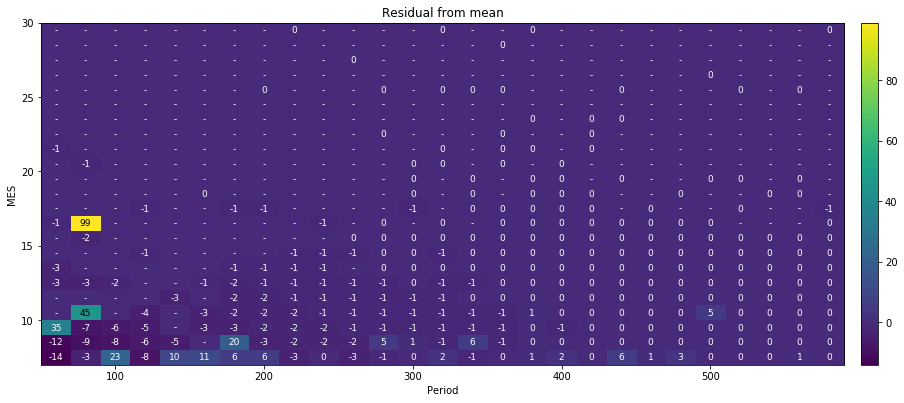

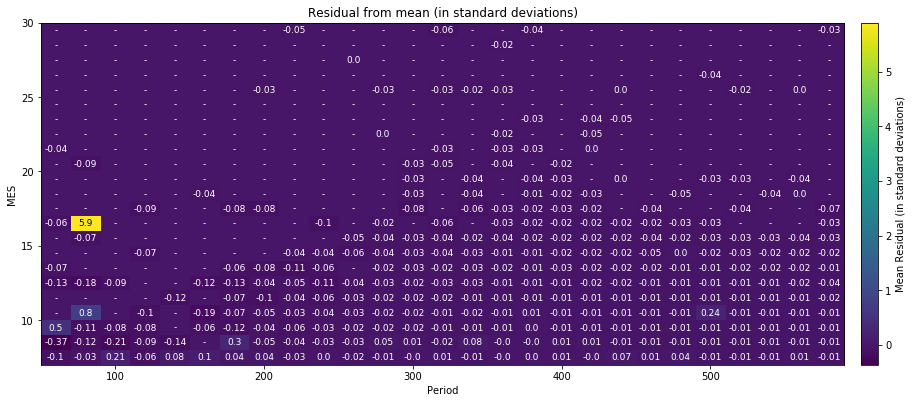

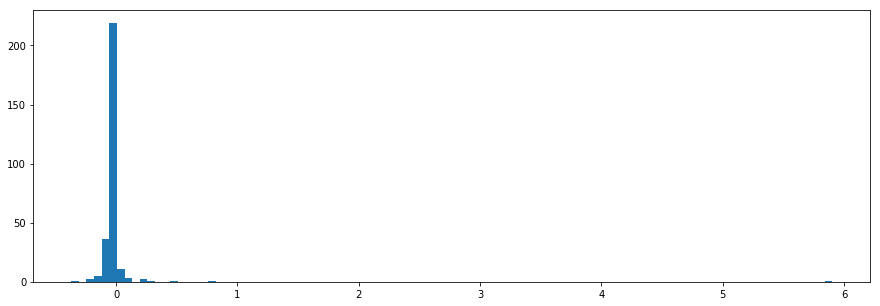

In [25]:

fitDiff = fitFracMean - fpFrac
fitDiffNorm =np.zeros(fitDiff.shape)
fitDiffNorm[stdFit>0] = fitDiff[stdFit>0]/stdFit[stdFit>0];

drawHeatMap(np.round(100*fitDiff), (15,15), cellPeriod, cellMes, nData = tceGrid);           
plt.title("Residual from mean");
plt.ylabel('MES');
plt.xlabel('Period');

drawHeatMap(np.round(fitDiffNorm, 2), (15,15), cellPeriod, cellMes, nData = tceGrid, 
            colorBarLabel="Mean Residual (in standard deviations)", forceInt = False); 
plt.ylabel('MES');
plt.xlabel('Period');
plt.savefig("fpEffMeanResid.eps",bbox_inches='tight')
plt.title("Residual from mean (in standard deviations)");

plt.figure(figsize=(15,5));
plt.hist(fitDiffNorm.flatten()[nTce > 0], 100);

np.median(fitDiffNorm.flatten()[nTce > 0])



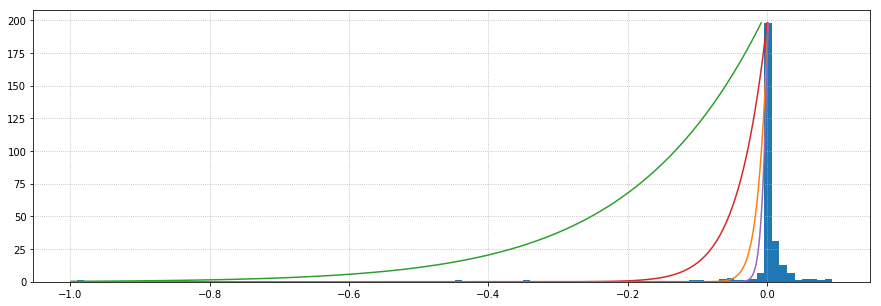

In [26]:
def binPdf(n, r, c):
    return spec.comb(n,c)*(r**c)*((1-r)**(n-c));

def plot_norm_bin(n, r, scale):
    xx = np.arange(0, n, 0.01)
    ix = np.arange(0, n)

    plt.plot(xx/n - r,scale*binPdf(n,r,xx)/max(binPdf(n,r,xx)));


residuals = np.zeros(np.shape(tceGrid));
rateGrid = np.zeros(np.shape(tceGrid));

for p in range(NPeriod):
    for m in range(NMes):
        rateGrid[(p,m)] = funcModels.rateModel(cellX[(p,m)]+dx/2, cellY[(p,m)]+dy/2, fitTheta, model);
        if tceGrid[(p,m)] > 0:
            residuals[(p,m)] = fpGrid[(p,m)]/tceGrid[(p,m)] - rateGrid[(p,m)]
            
rateFlat = rateGrid.flatten();
residualsFlat = residuals.flatten();
# group residuals by rate
plt.figure(figsize=(15,5));
histVals = plt.hist(residualsFlat[(rateFlat>0.9)&(nTce>0)], 100);
tcePctiles = np.percentile(nTce[(rateFlat>0.9)&(nTce>0)], [10, 50, 90], axis=0);
plot_norm_bin(np.mean(nTce[(rateFlat>0.9)&(nTce>0)]), np.median(rateFlat), np.max(histVals[0]))
plot_norm_bin(tcePctiles[0], np.median(rateFlat), np.max(histVals[0]))
plot_norm_bin(tcePctiles[1], np.median(rateFlat), np.max(histVals[0]))
plot_norm_bin(tcePctiles[2], np.median(rateFlat), np.max(histVals[0]))
plt.grid(linestyle = ':');


In [27]:
np.median(rateFlat)

0.9982725600715633

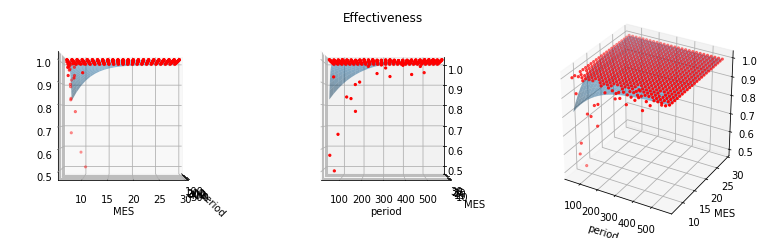

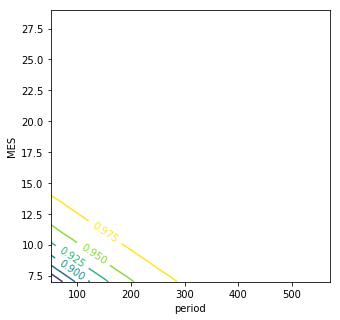

In [28]:
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm

fig = plt.figure(figsize=plt.figaspect(0.3));
ax = fig.add_subplot(1, 3, 1, projection='3d')
Z = funcModels.rateModel(cellX, cellY, fitTheta, model);
fpFracPlot = fpFrac
fpFrac[fpFrac == 0] = 1
surf = ax.plot_surface(cellPeriod, cellMes, Z, alpha = 0.5);
scat = ax.scatter(cellPeriod, cellMes, fpFrac, c='r', marker = '.');
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,0)

ax = fig.add_subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, Z, alpha = 0.5);
scat = ax.scatter(cellPeriod, cellMes, fpFrac, c='r', marker = '.');
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,-90)
plt.title("Effectiveness");

ax = fig.add_subplot(1, 3, 3, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, Z, alpha = 0.5);
scat = ax.scatter(cellPeriod, cellMes, fpFrac, c='r', marker = '.');
plt.xlabel("period");
plt.ylabel("MES");

fig, ax = plt.subplots(figsize=(5,5));
CS = ax.contour(cellPeriod, cellMes, Z);
ax.clabel(CS, inline=1, fontsize=10);
plt.xlabel("period");
plt.ylabel("MES");


In [29]:
funcModels.normalizeRange(372., 8., [periodMin, periodMax], [mesMin, mesMax])

(0.5854545454545454, 0.043478260869565216)

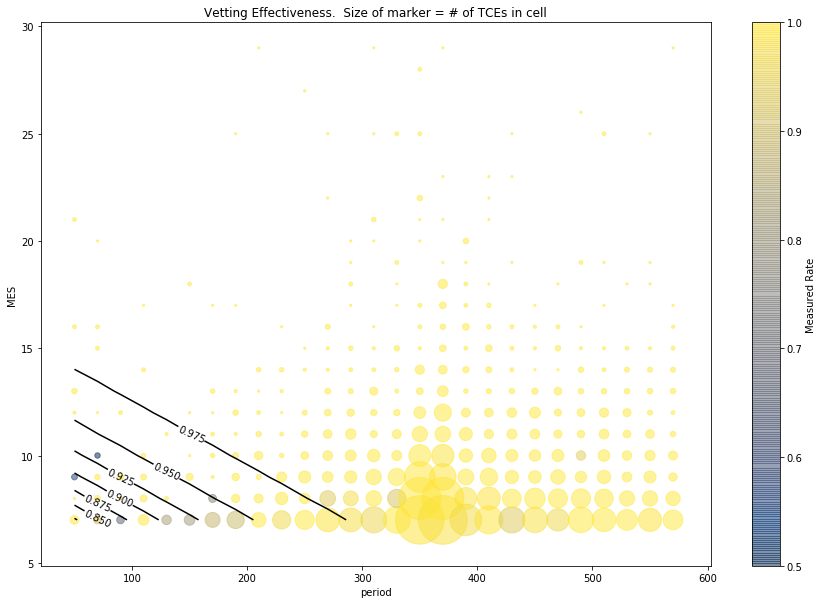

In [30]:
fig, ax = plt.subplots(figsize=(15,10));
Z = funcModels.rateModel(cellX, cellY, fitTheta, model);
CS = ax.contour(cellPeriod, cellMes, Z, colors='k');
ax.clabel(CS, inline=1, fontsize=10);
scf = ax.scatter(cellPeriod[tceGrid>0], cellMes[tceGrid>0], cmap="cividis", c=fpFrac[tceGrid>0], s=5*tceGrid[tceGrid>0], alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
plt.title("Vetting Effectiveness.  Size of marker = # of TCEs in cell");
cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Measured Rate");



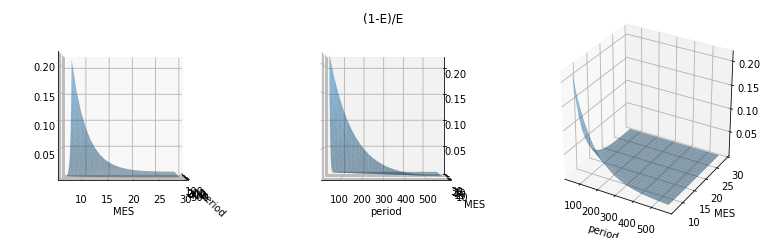

In [31]:

fig = plt.figure(figsize=plt.figaspect(0.3));
Z0 = funcModels.rateModel(cellX, cellY, fitTheta, model);
Z = (1-Z0)/Z0;

ax = fig.add_subplot(1, 3, 1, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, Z, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,0)

ax = fig.add_subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, Z, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,-90)
plt.title("(1-E)/E");

ax = fig.add_subplot(1, 3, 3, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, Z, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");

Fit $F_{\mathrm{obsFP}}$.

In [32]:
aic = 2*len(fitTheta) - 2*lnBinlike(fitTheta, tceData, model)
aic

283.76302110759195

In [33]:
maxLikelihoodAic = 2*len(maxLikelihoodResult) - 2*lnBinlike(maxLikelihoodResult, tceData, model)
maxLikelihoodAic

783.6644963201805

In [34]:
l = np.zeros(np.shape(samples)[0])
aicDist = np.zeros(np.shape(samples)[0])
progress = FloatProgress(min=0, max=samples.shape[0])
display(progress)

for i in range(np.shape(samples)[0]):
    l[i] = lnBinprob(samples[i,:], tceData, model)
    aicDist[i] = 2*len(samples[i,:]) - 2*lnBinlike(samples[i,:], tceData, model)
    progress.value += 1
    

FloatProgress(value=0.0, max=500000.0)

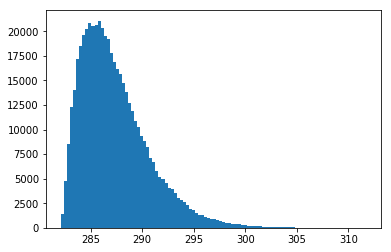

In [35]:
plt.hist(aicDist, 100);

In [36]:
min(aicDist)

282.1162630362904

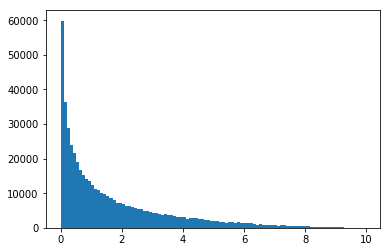

In [37]:
plt.hist(np.exp(l - np.median(l)), 100);

In [38]:
np.median(l)

-138.35705145772948

In [39]:
from skmonaco import mcquad

lbnds = np.empty([np.shape(samples)[1]])
ubnds = np.empty([np.shape(samples)[1]])
for i in range(len(lbnds)):
    lbnds[i] = np.min(samples[:,i])
    ubnds[i] = np.max(samples[:,i])

regularizationOffset = np.median(l)

def linBinProbInt(theta):
    return np.exp(lnBinprob(theta, tceData, model) - regularizationOffset)

BF, BFerror = mcquad(linBinProbInt, xl=lbnds,xu=ubnds, npoints=1e7,nprocs=8 )
print("BF = {:.3e} +/- {:.3e}").format(BF,BFerror)

BF = 2.687e-02 +/- 2.456e-04


In [40]:
import os.path
import pickle

fname = "fpEffectivenessTable.pkl"
if os.path.isfile(fname):
    modelComparisonTable = pd.read_pickle(fname)
else:
    modelComparisonTable = pd.DataFrame({"Model": ["rotatedLogisticX0", "rotatedLogisticX02", "constant", 
                                              "dualBrokenPowerLaw", "gaussian", "rotatedLogisticX0xlogisticY0",
                                              "rotatedLogisticX0+gaussian", "rotatedLogisticY", "rotatedLogisticYXLogisticY", 
                                              "logisticY", "rotatedLogisticYXFixedLogisticY"], 
                                    "medianMCMCAIC": [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                    "maxLikelihoodAIC": [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                    "MedianLogPost": [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                    "IntegralPost": [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                    "IntegralPostErr": [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                    "medianMCMCTheta": [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
                                    "maxLikelihoodTheta": [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
                                    "periodRange": [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]],
                                    "mesRange": [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]},
                                    columns=["Model","BayesFactor","BayesFactorError","AICRelativeProb",
                                             "medianMCMCAIC","maxLikelihoodAIC","IntegralPost",
                                             "IntegralPostErr","MedianLogPost","medianMCMCTheta",
                                             "maxLikelihoodTheta","periodRange","mesRange"])
    modelComparisonTable['IntegralPost'] = modelComparisonTable['IntegralPost'].map('{:,.3e}'.format)
    modelComparisonTable['IntegralPostErr'] = modelComparisonTable['IntegralPostErr'].map('{:,.3e}'.format)



In [41]:
mctIndex = np.where(modelComparisonTable["Model"].isin([model]))[0][0]
print(mctIndex)
modelComparisonTable["medianMCMCAIC"][mctIndex] = aic;
modelComparisonTable["maxLikelihoodAIC"][mctIndex] = maxLikelihoodAic;
modelComparisonTable["MedianLogPost"][mctIndex] = regularizationOffset;
modelComparisonTable["IntegralPost"][mctIndex] = BF;
modelComparisonTable["IntegralPostErr"][mctIndex] = BFerror;
modelComparisonTable["medianMCMCTheta"][mctIndex] = fitTheta;
modelComparisonTable["maxLikelihoodTheta"][mctIndex] = maxLikelihoodResult;
modelComparisonTable["periodRange"][mctIndex] = [periodMin, periodMax];
modelComparisonTable["mesRange"][mctIndex] = [mesMin, mesMax];

0


/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexin

In [42]:
modelToCompareIndex = 0
modelComparisonTable["AICRelativeProb"] = 0.
minAic = np.min(modelComparisonTable["medianMCMCAIC"][modelToCompareIndex])

for i in range(len(modelComparisonTable)):
    modelComparisonTable["AICRelativeProb"].iloc[i] = np.exp((minAic - modelComparisonTable["medianMCMCAIC"].iloc[i])/2.)
    

/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [43]:
modelComparisonTable["BayesFactor"] = 0.
c1 = modelComparisonTable["MedianLogPost"].iloc[modelToCompareIndex]
i1 = np.double(modelComparisonTable["IntegralPost"].iloc[modelToCompareIndex])
for i in range(len(modelComparisonTable)):
    c2 = modelComparisonTable["MedianLogPost"].iloc[i]
    modelComparisonTable["BayesFactor"].iloc[i] = np.exp(c2 - c1)*np.double(modelComparisonTable["IntegralPost"].iloc[i])/i1

In [44]:
modelComparisonTable["BayesFactorError"] = 0.
B = np.double(modelComparisonTable["IntegralPost"].iloc[modelToCompareIndex])
sB = np.double(modelComparisonTable["IntegralPostErr"].iloc[modelToCompareIndex])
c1 = modelComparisonTable["MedianLogPost"].iloc[modelToCompareIndex]
for i in range(len(modelComparisonTable)):
    c2 = modelComparisonTable["MedianLogPost"].iloc[i]
    f = np.double(modelComparisonTable["BayesFactor"].iloc[i])
    A = np.exp(c2 - c1)*np.double(modelComparisonTable["IntegralPost"].iloc[i])
    sA = np.exp(c2 - c1)*np.double(modelComparisonTable["IntegralPostErr"].iloc[i])
    modelComparisonTable["BayesFactorError"].iloc[i] = f*np.sqrt((sA/A)**2 + (sB/B)**2)

/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [45]:
modelComparisonTable

,Model,BayesFactor,BayesFactorError,AICRelativeProb,medianMCMCAIC,maxLikelihoodAIC,IntegralPost,IntegralPostErr,MedianLogPost,medianMCMCTheta,maxLikelihoodTheta,periodRange,mesRange
0,rotatedLogisticX0,1.0,0.012924,1.000000e+00,283.763021,783.664496,0.0268741,0.000245591,-138.357051,"[1.3728373774971367, 8.757002079510476, 0.9987...","[1.2, 9.7715652, 0.99773284, 106.91479715]","[50, 600]","[7, 30]"
1,rotatedLogisticX02,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
2,constant,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
3,dualBrokenPowerLaw,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
4,gaussian,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
5,rotatedLogisticX0xlogisticY0,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
6,rotatedLogisticX0+gaussian,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
7,rotatedLogisticY,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
8,rotatedLogisticYXLogisticY,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
9,logisticY,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]


In [46]:
modelComparisonTable.to_pickle(fname)

In [47]:
tt = pd.read_pickle(fname)
tt

,Model,BayesFactor,BayesFactorError,AICRelativeProb,medianMCMCAIC,maxLikelihoodAIC,IntegralPost,IntegralPostErr,MedianLogPost,medianMCMCTheta,maxLikelihoodTheta,periodRange,mesRange
0,rotatedLogisticX0,1.0,0.012924,1.000000e+00,283.763021,783.664496,0.0268741,0.000245591,-138.357051,"[1.3728373774971367, 8.757002079510476, 0.9987...","[1.2, 9.7715652, 0.99773284, 106.91479715]","[50, 600]","[7, 30]"
1,rotatedLogisticX02,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
2,constant,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
3,dualBrokenPowerLaw,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
4,gaussian,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
5,rotatedLogisticX0xlogisticY0,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
6,rotatedLogisticX0+gaussian,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
7,rotatedLogisticY,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
8,rotatedLogisticYXLogisticY,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
9,logisticY,0.0,NaN,4.152954e+61,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]


In [48]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [49]:
%%bash -s "$model"
jupyter nbconvert --to html binomialFPEffectiveness.ipynb
mv binomialFPEffectiveness.html htmlArchive/binomialFPEffectiveness_$1.html

[NbConvertApp] Converting notebook binomialFPEffectiveness.ipynb to html
[NbConvertApp] Writing 1776016 bytes to binomialFPEffectiveness.html
